In [184]:
import pandas as pd
import sqlite3
import os

import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

In [185]:
# Open SQL Database and initialize dataframe
path = "../Algorithm/data"
conn = sqlite3.connect("C:\\Users\\charl\\Desktop\\Algorithm\\data\\Prediction.db")
orig_df = pd.read_sql_query("SELECT * FROM BLAZERS", conn)

In [261]:
# Add remaining teams to the end of the dataframe
teams = ["BLAZERS", "BUCKS", "BULLS", "CAVALIERS", "CELTICS", "CLIPPERS", "GRIZZLIES", "HAWKS", "HEAT", "HORNETS", "JAZZ", "KINGS", "KNICKS", "LAKERS", "MAGIC", "MAVERICKS", "NETS", "NUGGETS", "PACERS", "PELICANS", "PISTONS", "RAPTORS", "ROCKETS", "SIXERS", "SPURS", "SUNS", "THUNDER", "TIMBERWOLVES", "WARRIORS", "WIZARDS"]

for team in teams[1:]:
    temp_df = pd.read_sql_query("SELECT * FROM " + team, conn)
    orig_df = pd.concat([orig_df, temp_df], axis=0)

In [262]:
orig_df

,game_ID,game_date,home_team,away_team,TO_1,three_m1,three_a1,ts_1,diff_1,TO_2,...,ts_3,diff_3,ts_final,home_ppg,home_oppg,away_ppg,away_oppg,avg_points_scored,avg_points_allowed,percent_3pt_2
0,21901289,2020-08-09 00:00:00,BLAZERS,SIXERS,7,4,12,52,14,13,...,183,1,245.0,115.0,116.1,110.7,108.4,112.85,112.25,0.357143
1,21901280,2020-08-08 00:00:00,BLAZERS,CLIPPERS,8,8,15,71,3,15,...,191,1,239.0,115.0,116.1,116.3,109.9,115.65,113.00,0.514286
2,21901261,2020-08-04 00:00:00,BLAZERS,ROCKETS,6,8,21,53,5,10,...,166,6,212.0,115.0,116.1,117.8,114.8,116.40,115.45,0.409091
3,21901234,2020-07-31 00:00:00,BLAZERS,GRIZZLIES,6,6,14,65,5,15,...,189,3,275.0,115.0,116.1,112.6,113.7,113.80,114.90,0.343750
4,21900966,2020-03-10 00:00:00,BLAZERS,SUNS,6,7,15,64,8,14,...,160,4,236.4,115.0,116.1,113.6,113.4,114.30,114.75,0.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,21300189,2013-11-23,WIZARDS,KNICKS,9,5,11,53,1,4,...,145,7,187.0,100.7,99.4,98.6,99.4,NaN,NaN,NaN
284,21300156,2013-11-19,WIZARDS,TIMBERWOLVES,5,5,11,61,7,2,...,162,0,204.0,100.7,99.4,106.9,104.3,NaN,NaN,NaN
285,21300138,2013-11-16,WIZARDS,CAVALIERS,16,2,10,43,7,8,...,133,5,199.0,100.7,99.4,98.2,101.5,NaN,NaN,NaN
286,21300077,2013-11-08,WIZARDS,NETS,4,6,13,60,6,9,...,146,0,220.0,100.7,99.4,98.5,99.5,NaN,NaN,NaN


In [263]:
orig_df.head()

,game_ID,game_date,home_team,away_team,TO_1,three_m1,three_a1,ts_1,diff_1,TO_2,...,ts_3,diff_3,ts_final,home_ppg,home_oppg,away_ppg,away_oppg,avg_points_scored,avg_points_allowed,percent_3pt_2
0,21901289,2020-08-09 00:00:00,BLAZERS,SIXERS,7,4,12,52,14,13,...,183,1,245.0,115.0,116.1,110.7,108.4,112.85,112.25,0.357143
1,21901280,2020-08-08 00:00:00,BLAZERS,CLIPPERS,8,8,15,71,3,15,...,191,1,239.0,115.0,116.1,116.3,109.9,115.65,113.00,0.514286
2,21901261,2020-08-04 00:00:00,BLAZERS,ROCKETS,6,8,21,53,5,10,...,166,6,212.0,115.0,116.1,117.8,114.8,116.40,115.45,0.409091
3,21901234,2020-07-31 00:00:00,BLAZERS,GRIZZLIES,6,6,14,65,5,15,...,189,3,275.0,115.0,116.1,112.6,113.7,113.80,114.90,0.343750
4,21900966,2020-03-10 00:00:00,BLAZERS,SUNS,6,7,15,64,8,14,...,160,4,236.4,115.0,116.1,113.6,113.4,114.30,114.75,0.375000


In [264]:
orig_df['game_date'] = pd.to_datetime(orig_df['game_date'])
orig_df['avg_points_scored'] = (orig_df['home_ppg'] + orig_df['away_ppg'])/2
orig_df['avg_points_allowed'] = (orig_df['home_oppg'] + orig_df['away_oppg'])/2
orig_df["TO_2"] = orig_df["TO_2"] + orig_df["TO_1"]
orig_df['TO_3'] = orig_df["TO_3"] + orig_df["TO_2"]
orig_df["three_a2"] = orig_df["three_a2"] + orig_df["three_a1"]
orig_df['three_a3'] = orig_df["three_a3"] + orig_df["three_a2"]
orig_df["three_m2"] = orig_df["three_m2"] + orig_df["three_m1"]
orig_df['three_m3'] = orig_df["three_m3"] + orig_df["three_m2"]
orig_df['percent_3pt_2'] = orig_df['three_m2']/orig_df['three_a2']

In [265]:
orig_df.head()

,game_ID,game_date,home_team,away_team,TO_1,three_m1,three_a1,ts_1,diff_1,TO_2,...,ts_3,diff_3,ts_final,home_ppg,home_oppg,away_ppg,away_oppg,avg_points_scored,avg_points_allowed,percent_3pt_2
0,21901289,2020-08-09,BLAZERS,SIXERS,7,4,12,52,14,20,...,183,1,245.0,115.0,116.1,110.7,108.4,112.85,112.25,0.350000
1,21901280,2020-08-08,BLAZERS,CLIPPERS,8,8,15,71,3,23,...,191,1,239.0,115.0,116.1,116.3,109.9,115.65,113.00,0.520000
2,21901261,2020-08-04,BLAZERS,ROCKETS,6,8,21,53,5,16,...,166,6,212.0,115.0,116.1,117.8,114.8,116.40,115.45,0.400000
3,21901234,2020-07-31,BLAZERS,GRIZZLIES,6,6,14,65,5,21,...,189,3,275.0,115.0,116.1,112.6,113.7,113.80,114.90,0.369565
4,21900966,2020-03-10,BLAZERS,SUNS,6,7,15,64,8,20,...,160,4,236.4,115.0,116.1,113.6,113.4,114.30,114.75,0.404255


In [266]:
orig_df.columns

Index(['game_ID', 'game_date', 'home_team', 'away_team', 'TO_1', 'three_m1',
       'three_a1', 'ts_1', 'diff_1', 'TO_2', 'three_m2', 'three_a2', 'ts_2',
       'diff_2', 'TO_3', 'three_m3', 'three_a3', 'ts_3', 'diff_3', 'ts_final',
       'home_ppg', 'home_oppg', 'away_ppg', 'away_oppg', 'avg_points_scored',
       'avg_points_allowed', 'percent_3pt_2'],
      dtype='object')

In [267]:
orig_df

,game_ID,game_date,home_team,away_team,TO_1,three_m1,three_a1,ts_1,diff_1,TO_2,...,ts_3,diff_3,ts_final,home_ppg,home_oppg,away_ppg,away_oppg,avg_points_scored,avg_points_allowed,percent_3pt_2
0,21901289,2020-08-09,BLAZERS,SIXERS,7,4,12,52,14,20,...,183,1,245.0,115.0,116.1,110.7,108.4,112.85,112.25,0.350000
1,21901280,2020-08-08,BLAZERS,CLIPPERS,8,8,15,71,3,23,...,191,1,239.0,115.0,116.1,116.3,109.9,115.65,113.00,0.520000
2,21901261,2020-08-04,BLAZERS,ROCKETS,6,8,21,53,5,16,...,166,6,212.0,115.0,116.1,117.8,114.8,116.40,115.45,0.400000
3,21901234,2020-07-31,BLAZERS,GRIZZLIES,6,6,14,65,5,21,...,189,3,275.0,115.0,116.1,112.6,113.7,113.80,114.90,0.369565
4,21900966,2020-03-10,BLAZERS,SUNS,6,7,15,64,8,20,...,160,4,236.4,115.0,116.1,113.6,113.4,114.30,114.75,0.404255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,21300189,2013-11-23,WIZARDS,KNICKS,9,5,11,53,1,13,...,145,7,187.0,100.7,99.4,98.6,99.4,99.65,99.40,0.437500
284,21300156,2013-11-19,WIZARDS,TIMBERWOLVES,5,5,11,61,7,7,...,162,0,204.0,100.7,99.4,106.9,104.3,103.80,101.85,0.400000
285,21300138,2013-11-16,WIZARDS,CAVALIERS,16,2,10,43,7,24,...,133,5,199.0,100.7,99.4,98.2,101.5,99.45,100.45,0.391304
286,21300077,2013-11-08,WIZARDS,NETS,4,6,13,60,6,13,...,146,0,220.0,100.7,99.4,98.5,99.5,99.60,99.45,0.478261


In [268]:
features = ['ts_2', 'ts_final', 'avg_points_scored', 'avg_points_allowed']

In [269]:
df = orig_df[features]

In [270]:
df.sample(20)

,ts_2,ts_final,avg_points_scored,avg_points_allowed
204,103,227.0,99.55,105.75
204,114,218.0,104.15,97.50
259,103,210.0,99.95,105.10
245,103,218.0,104.20,102.20
161,110,233.0,107.80,110.90
92,100,212.0,108.00,107.00
76,85,182.0,109.10,116.40
113,105,207.0,104.70,104.05
115,122,247.0,106.45,105.10
277,97,222.0,101.80,99.55


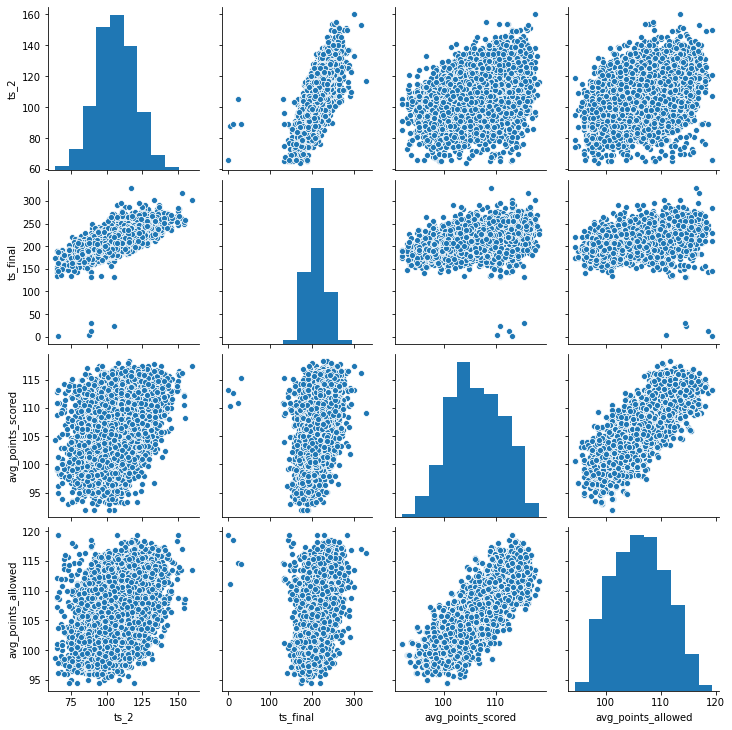

In [156]:
sns.pairplot(df)

,ts_2,ts_final,avg_points_scored,avg_points_allowed
ts_2,1.000000,0.741812,0.402579,0.396298
ts_final,0.741812,1.000000,0.440620,0.419977
avg_points_scored,0.402579,0.440620,1.000000,0.787421
avg_points_allowed,0.396298,0.419977,0.787421,1.000000


<AxesSubplot:>

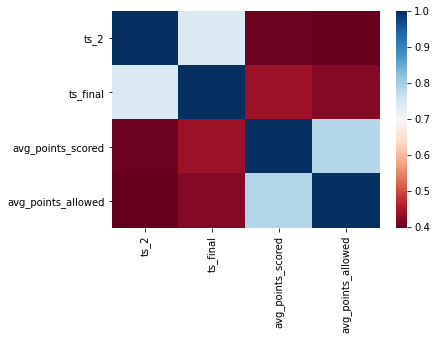

In [157]:
# check for multicolinearity
corr = df.corr()
display(corr)

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

In [243]:
# Heatmap tells us that score_rate, time_remaining, and score_diff are uncorrelated enough to include. 

# the VFI does expect a constant term in the data, so we need to add one using the add_constant method
X1 = sm.tools.add_constant(df)


# create the series for both
series_before = pd.Series([variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])], index=X1.columns)


# display the series
print('DATA BEFORE')
print('-'*100)
display(series_before)

DATA BEFORE
----------------------------------------------------------------------------------------------------


const                 487.052375
ts_2                    2.292876
ts_final                2.387998
avg_points_scored       2.834492
avg_points_allowed      2.790217
dtype: float64

In [244]:
# Given all of our variables have low correlation values (well under 5), we can confirm they are okay to be included
desc = df.describe()
desc

,ts_2,ts_final,avg_points_scored,avg_points_allowed
count,8527.000000,8527.000000,8527.000000,8527.000000
mean,105.525390,210.297432,105.441586,105.461997
std,13.458445,22.361762,5.149629,5.000067
min,64.000000,0.800000,91.950000,92.050000
25%,96.000000,195.000000,101.550000,101.500000
50%,105.000000,209.000000,104.950000,105.100000
75%,114.000000,225.000000,109.450000,109.150000
max,160.000000,329.000000,118.250000,119.400000


In [245]:
#df = df[df['diff_1'] < 29]
df = df[df['ts_final'] > 144]
df = df[df['ts_final'] < 276]


In [246]:
#build the model
X = df.drop('ts_final', axis = 1)
Y = df["ts_final"]

#Split data into test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

# Fit the model
regression_model = LinearRegression()
regression_model.fit(X_train, Y_train)

LinearRegression()

In [247]:
# Print out results of the model
intercept = regression_model.intercept_
coefficent = regression_model.coef_[0]

print("The intercept for our model is {:.4}".format(intercept))
print('-'*100)

for coef in zip(X.columns, regression_model.coef_):
    print("The Coefficient for {} is {:.2}".format(coef[0],coef[1]))

The intercept for our model is 3.132
----------------------------------------------------------------------------------------------------
The Coefficient for ts_2 is 1.1
The Coefficient for avg_points_scored is 0.54
The Coefficient for avg_points_allowed is 0.36


In [248]:
Y_predict = regression_model.predict(X_test)

In [249]:
Y_predict

array([203.12954519, 237.81258093, 227.97438687, 192.58825171,
       209.50104403, 209.79137724, 212.60717072, 201.30943608,
       226.38012532, 189.15147161, 206.67976371, 224.95187651,
       227.78469908, 219.80313338, 187.89057659, 192.45846384,
       192.33821446, 204.50202044, 203.51372269, 207.54252932,
       204.55317878, 214.95350391, 206.01256397, 215.72831291,
       238.87953745, 207.42319316, 220.24175804, 195.36790234,
       224.14246749, 192.17271888, 212.74023025, 229.91845445,
       201.15252188, 204.1876943 , 206.3261908 , 219.86965207,
       231.67735186, 191.15394999, 239.10059497, 203.31576683,
       221.93080887, 194.55299666, 198.86461161, 208.48560784,
       230.57263265, 208.38056111, 208.697836  , 201.62190881,
       186.22843566, 224.49036161, 213.42464625, 224.69489988,
       195.04312451, 198.83476255, 215.36316346, 195.29806559,
       227.55668024, 211.91173695, 226.80388485, 205.53161764,
       212.92572562, 228.87421815, 214.85417506, 213.09

In [250]:
print('Train Score :', regression_model.score(X_train,Y_train))
print('Test Score:', regression_model.score(X_test,Y_test))

Train Score : 0.6080215412888248
Test Score: 0.5703924397876394


In [251]:
# Applying model to be used with the statsmodel package (needs a constant) 
X2 = sm.add_constant(X)

# create a OLS model
model = sm.OLS(Y, X2)


# fit the data
est = model.fit()
est.pvalues

const                 5.230320e-01
ts_2                  0.000000e+00
avg_points_scored     2.193766e-32
avg_points_allowed    5.191043e-13
dtype: float64

In [252]:
#White's test for heteroscedasticity
_, pval, __, f_pval = diag.het_white(est.resid, est.model.exog)
print(pval, f_pval)
print('-'*100)

if pval > 0.05:
    print("For the White's Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypthoesis, so there is no heterosecdasticity. \n")
    
else:
    print("For the White's Test")
    print("The p-value was {:.4}".format(pval))
    
_, pval, __, f_pval = diag.het_breuschpagan(est.resid, est.model.exog)
print(pval, f_pval)
print('-'*100)

4.4931637416550945e-09 4.205301871696252e-09
----------------------------------------------------------------------------------------------------
For the White's Test
The p-value was 4.493e-09
2.2992681091181276e-05 2.27232996033026e-05
----------------------------------------------------------------------------------------------------


In [253]:
model = sm.OLS(Y, X2)
est = model.fit()

_, pval, __, f_pval = diag.het_white(est.resid, est.model.exog)
print(pval, f_pval)

4.4931637416550945e-09 4.205301871696252e-09


C:\Users\charl\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:496: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)
C:\Users\charl\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


The lowest p-value found was 1.998e-05
We reject the null hypthoesis, so there is autocorrelation.
----------------------------------------------------------------------------------------------------


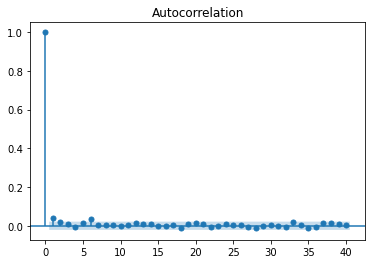

In [254]:
# test for autocorrelation

from statsmodels.stats.stattools import durbin_watson

test_results = diag.acorr_ljungbox(est.resid)
ibvalue, p_val = test_results

if min(p_val) > 0.05:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We fail to reject the null hypthoesis, so there is no autocorrelation.")
    print('-'*100)
else:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We reject the null hypthoesis, so there is autocorrelation.")
    print('-'*100)
    
sm.graphics.tsa.plot_acf(est.resid)
plt.show()

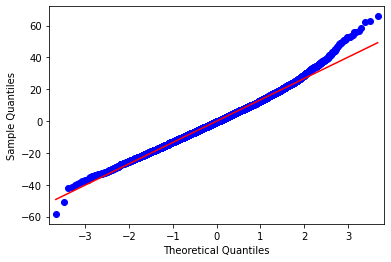

The mean of the residuals is 2.23e-13


In [255]:
import pylab

# check for the normality of the residuals
sm.qqplot(est.resid, line='s')
pylab.show()

mean_residuals = sum(est.resid)/ len(est.resid)
print("The mean of the residuals is {:.4}".format(mean_residuals))

In [256]:
import math
# calculate the mean squared error
model_mse = mean_squared_error(Y_test, Y_predict)

# calculate the mean absolute error
model_mae = mean_absolute_error(Y_test, Y_predict)

# calulcate the root mean squared error
model_rmse =  math.sqrt(model_mse)

# display the output
print("MSE {:.3}".format(model_mse))
print("MAE {:.3}".format(model_mae))
print("RMSE {:.3}".format(model_rmse))

MSE 1.77e+02
MAE 10.3
RMSE 13.3


In [257]:
model_r2 = r2_score(Y_test, Y_predict)
print("R2: {:.2}".format(model_r2))

R2: 0.57


In [258]:
est.conf_int()

,0,1
const,-4.254192,8.366329
ts_2,1.037380,1.084887
avg_points_scored,0.469050,0.654093
avg_points_allowed,0.256260,0.446851


In [259]:
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               ts_final   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     4326.
Date:                Thu, 17 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:52:18   Log-Likelihood:                -34061.
No. Observations:                8486   AIC:                         6.813e+04
Df Residuals:                    8482   BIC:                         6.816e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.0561      3

In [260]:
import csv
with open('../training_combinations/quarter_2_stats.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    row = [features, model_mse, model_mae, model_rmse, model_r2, "Within 3 standard deviations in either direction"]
    writer.writerow(row)

In [271]:
import pickle

# pickle the model
with open('../Models/predict_2.sav','wb') as f:
     pickle.dump(regression_model, f)